In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

In [3]:
# define some variables
y, n = sym.symbols('y, n')

# specify some parameters
alpha= sym.symbols('alpha')

# define the model
n_dot = (n**-1 - alpha * n * y**(alpha - 1)) / y**alpha 
rhs = {n: n_dot}

# define some boundary conditions
nL = 1.0
yL = (nL**2 * alpha)**(1 / (1 - alpha))
yU = 1e2

bcs = {'lower': [y - yL], 'upper': None}

spence = pycollocation.BoundaryValueProblem(dependent_vars=[n],
                                            independent_var=y,
                                            rhs=rhs,
                                            boundary_conditions=bcs)

spence_params = {'alpha': 0.15}

spence_solver = pycollocation.OrthogonalPolynomialSolver(spence, spence_params)

In [4]:
domain = [float(yL.evalf(subs=spence_params)), yU]
ys = np.linspace(domain[0], domain[1], 1000)
ns = ys**0.5  # guess some generic concave function
initial_type_poly = np.polynomial.Chebyshev.fit(ys, ns, 150, domain)

initial_spence_coefs = {n: initial_type_poly.coef}

In [5]:
spence_solver.solve(kind="Chebyshev",
                    coefs_dict=initial_spence_coefs,
                    domain=domain)


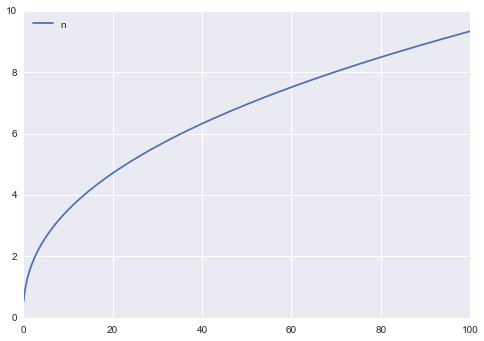

In [7]:
spence_solution = pycollocation.Solution(spence_solver)
spence_solution.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
spence_solution.solution.plot()

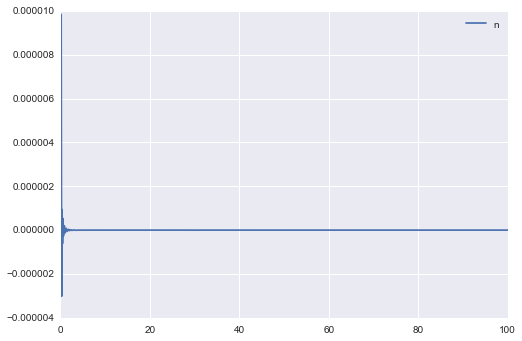

In [8]:
spence_solution.residuals.plot()

In [106]:
def spence_analytic_solution(y, nL, yL, alpha):
    """
    Analytic solution to the differential equation describing the signaling
    equilbrium of the Spence (1974) model.
    
    """    
    # compute analytic solution for worker type given y
    D = ((1 + alpha) / 2) * (nL / yL**-alpha)**2 - yL**(1 + alpha)
    return y**(-alpha) * (2 * (y**(1 + alpha) + D) / (1 + alpha))**0.5